Import prices

In [5]:
import yfinance as yf

msft = yf.Ticker("MSFT")

hist = msft.history(period="1y")

hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-05-29,180.977673,182.502914,178.679929,181.492691,42130400,0.0,0
2020-06-01,180.789494,181.245089,179.719864,181.076721,22622400,0.0,0
2020-06-02,182.483090,183.225898,179.610906,183.136765,30794600,0.0,0
2020-06-03,183.047644,184.156898,181.819529,183.582458,27311000,0.0,0
2020-06-04,182.532634,184.057860,180.551813,181.165863,28761800,0.0,0
...,...,...,...,...,...,...,...
2021-05-24,247.789993,251.160004,247.509995,250.779999,21411500,0.0,0
2021-05-25,251.770004,252.750000,250.820007,251.720001,17704300,0.0,0
2021-05-26,251.429993,252.940002,250.750000,251.490005,17771600,0.0,0


Window prices into 30 day windows

In [6]:
import numpy as np

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

window_data = rolling_window(hist['Close'].values, 30)

print(window_data)

array([[181.49269104, 181.07672119, 183.13676453, ..., 210.78903198,
        212.26473999, 211.62097168],
       [181.07672119, 183.13676453, 183.5824585 , ..., 212.26473999,
        211.62097168, 205.08425903],
       [183.13676453, 183.5824585 , 181.16586304, ..., 211.62097168,
        205.08425903, 206.35197449],
       ...,
       [258.90216064, 260.13931274, 258.1439209 , ..., 250.77999878,
        251.72000122, 251.49000549],
       [260.13931274, 258.1439209 , 257.66503906, ..., 251.72000122,
        251.49000549, 249.30999756],
       [258.1439209 , 257.66503906, 259.97967529, ..., 251.49000549,
        249.30999756, 249.67999268]])

In [14]:
from statsmodels.nonparametric.kernel_regression import KernelReg as kr 

def run_kernel_regressions(window_data: np.array, ) -> list: 
    result_list = []
    for i in range(0, len(window_data)):
        
        temp_window_data = {}
        temp_window_data['closing_prices'] = window_data[i]
        
        exog = [i for i in range(0, len(temp_window_data['closing_prices']))]
        
        regression_result = kr(endog=temp_window_data['closing_prices'], exog=exog, var_type='c', )
        regression_result = regression_result.fit()[0]
        
        temp_window_data['kernel_regression_line'] = regression_result
        
        result_list = result_list + [temp_window_data, ]

    return result_list

result_list = run_kernel_regressions(window_data=window_data, )

print(result_list)

[{'closing_prices': array([181.49269104, 181.07672119, 183.13676453, 183.5824585 ,
       181.16586304, 185.40480042, 186.55368042, 187.97988892,
       194.95236206, 184.48373413, 185.93962097, 187.12811279,
       191.71374512, 192.37728882, 194.43736267, 193.27856445,
       198.64660645, 199.97373962, 195.94277954, 198.41879272,
       194.44723511, 196.53701782, 201.55839539, 202.73698425,
       204.28201294, 208.67944336, 206.25292969, 210.78903198,
       212.26473999, 211.62097168]), 'kernel_regression_line': array([180.8052543 , 181.65931072, 182.51684287, 183.37755757,
       184.24203271, 185.11154121, 185.98780068, 186.87269216,
       187.76799985, 188.67522158, 189.59548577, 190.52958952,
       191.47814775, 192.44182324, 193.42159593, 194.41902716,
       195.43647805, 196.47724631, 197.54558948, 198.64660911,
       199.78598171, 200.96954248, 202.20275425, 203.49011933,
       204.83460903, 206.2371885 , 207.69650177, 209.20875736,
       210.76782424, 212.36551776])

Turn Regression results into 2d array

In [ ]:
# def list_result_to_array(input_list: list, ) -> np.array:
    
#     result = [i[0] for i in input_list] 
#     result = np.stack(result, axis=0)
    
#     return result

# result_array = list_result_to_array(input_list=result_list, )
# print(result_array)

Find local maxima and minima

In [31]:


from scipy.signal import argrelextrema


def find_extrema_from_list_of_series(window_data: dict, ) -> list:
    
    result_list = []
    for i in range(0, len(window_data)):
        
        temp_window_data = window_data[i]
        
        temp_window_data['extrema_x_vals'] = find_extrema(regression_line=temp_window_data['kernel_regression_line'], )
        temp_window_data['extrema_y_vals'] = [
            temp_window_data['kernel_regression_line'][i] for i in temp_window_data['extrema_x_vals']]
        
        result_list = result_list + [temp_window_data, ]
        
    return result_list


def find_extrema(regression_line) -> list:

    local_maxima_coords = list(argrelextrema(regression_line, np.greater, )[0])

    local_minima_coords = list(argrelextrema(regression_line, np.less, )[0])
    
    local_extrema_coords = local_minima_coords + local_maxima_coords
    
    local_extrema_coords.sort()
    
    return local_extrema_coords
    
    
result_list_2 = find_extrema_from_list_of_series(window_data=result_list, )    

print(result_list_2[160])

{'closing_prices': array([211.6725769 , 215.44517517, 223.30885315, 223.93595886,
       224.91145325, 228.47499084, 231.26213074, 231.82951355,
       237.83178711, 230.8938446 , 238.54847717, 238.40911865,
       241.88308716, 240.89762878, 241.08676147, 241.35552979,
       242.64953613, 241.70391846, 243.36624146, 243.86393738,
       242.5798645 , 243.63742065, 243.22834778, 240.41485596,
       233.96974182, 232.73260498, 234.00965881, 228.46246338,
       231.84465027, 236.39414978]), 'kernel_regression_line': array([211.43651673, 216.35690939, 220.62312902, 223.60211684,
       225.87900089, 228.24235948, 230.63957121, 232.73243209,
       234.15701484, 235.21341318, 236.87115696, 238.85560203,
       240.3040512 , 240.97744975, 241.2723401 , 241.62499958,
       242.04393972, 242.47350973, 242.93520886, 243.20619264,
       243.18863064, 242.86547518, 241.65734818, 239.10797527,
       236.0519772 , 233.78166461, 232.36804287, 231.74530385,
       232.79125875, 235.84962958]),

Head and shoulders graph consists of 5 extrema

In [34]:

def find_series_with_5_or_more_extrema(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):
        
        if len(window_data[i]['extrema_x_vals']) >= 5:
        
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_greater_than_4_extrema = find_series_with_5_or_more_extrema(window_data=result_list_2)
print(window_data_greater_than_4_extrema[6])

{'closing_prices': array([184.48373413, 185.93962097, 187.12811279, 191.71374512,
       192.37728882, 194.43736267, 193.27856445, 198.64660645,
       199.97373962, 195.94277954, 198.41879272, 194.44723511,
       196.53701782, 201.55839539, 202.73698425, 204.28201294,
       208.67944336, 206.25292969, 210.78903198, 212.26473999,
       211.62097168, 205.08425903, 206.35197449, 206.04493713,
       201.96446228, 200.93444824, 209.5708313 , 206.74815369,
       209.71936035, 200.59768677]), 'kernel_regression_line': array([184.32167622, 186.07341292, 188.18465813, 190.37606354,
       192.25187243, 193.78937644, 195.33810113, 196.84251956,
       197.6280683 , 197.48493317, 197.0248186 , 197.06965889,
       198.24144333, 200.36262535, 202.68705299, 204.80835072,
       206.63861521, 208.23570609, 209.61246902, 210.17793543,
       209.36193095, 207.69814806, 206.12845501, 204.85816919,
       204.10878079, 204.56803392, 205.93861774, 206.75617822,
       205.802463  , 202.45709422]),

Find Head and shoulders graphs if any

In [40]:

def find_head_and_shoulders(window_data: list, ) -> list:
    
    result_list = []
    
    for i in range(0, len(window_data)):

        # TODO: test for head and shoulders E1 is max, E1<E3>E5
        extrema_y_vals = window_data[i]['extrema_y_vals']
        
        e1_is_local_maxima = extrema_y_vals[0] > extrema_y_vals[1]
        e3_is_greater_than_e1 = extrema_y_vals[2] > extrema_y_vals[0]
        e3_is_greater_than_e5 = extrema_y_vals[2] > extrema_y_vals[4]
        
        e2_e4_avg = (extrema_y_vals[1] + extrema_y_vals[3]) / 2
        e2_within_15b_of_e2_e4_avg = abs(extrema_y_vals[1] / e2_e4_avg - 1) <= 0.015
        e4_within_15b_of_e2_e4_avg = abs(extrema_y_vals[3] / e2_e4_avg - 1) <= 0.015
        e2_and_e4_within_15_basis_points_of_their_average = e4_within_15b_of_e2_e4_avg and e2_within_15b_of_e2_e4_avg
        
        e1_e5_avg = (extrema_y_vals[0] + extrema_y_vals[4]) / 2
        e1_within_15b_of_e1_e5_avg = abs(extrema_y_vals[0] / e2_e4_avg - 1) <= 0.015
        e5_within_15b_of_e1_e5_avg = abs(extrema_y_vals[4] / e2_e4_avg - 1) <= 0.015
        e1_and_e5_within_15_basis_points_of_their_average = e1_within_15b_of_e1_e5_avg and e5_within_15b_of_e1_e5_avg
        
        
        price_series_has_head_and_shoulders = (
            e1_is_local_maxima and e3_is_greater_than_e1 and e3_is_greater_than_e5 
            and e2_and_e4_within_15_basis_points_of_their_average and e1_and_e5_within_15_basis_points_of_their_average)
        
        if price_series_has_head_and_shoulders:
            result_list = result_list + [window_data[i], ]
        
    return result_list

window_data_head_and_shoulders = find_head_and_shoulders(window_data=window_data_greater_than_4_extrema)

print(window_data_head_and_shoulders)

[{'closing_prices': array([213.25527954, 213.37472534, 213.30503845, 215.01713562,
       210.82649231, 209.55238342, 212.2797699 , 213.2154541 ,
       213.14579773, 218.27210999, 218.41146851, 217.58528137,
       221.56689453, 222.91069031, 220.00410461, 221.72616577,
       223.92599487, 223.11972046, 220.66107178, 221.39767456,
       216.68942261, 216.8984375 , 211.27441406, 217.28665161,
       218.61054993, 216.49034119, 213.9420929 , 215.34562683,
       212.0408783 , 211.6725769 ]), 'kernel_regression_line': array([213.24502862, 213.40176663, 213.36040057, 212.85009995,
       212.04526255, 211.6511809 , 212.11231209, 213.25133802,
       214.80446381, 216.48122092, 217.93690424, 219.2057048 ,
       220.37701772, 221.17602539, 221.60447525, 222.03551228,
       222.36905844, 222.12304319, 221.16753773, 219.67191558,
       217.87495623, 216.29990975, 215.65983505, 216.02629436,
       216.43118905, 216.05944749, 215.10096962, 213.97589016,
       212.75191256, 211.4681459 ])

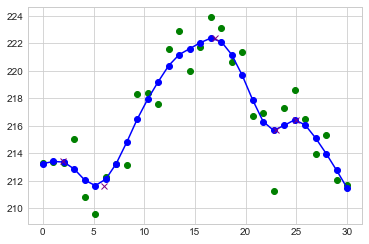

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_chart(price_series_data: dict) -> None:
    plt.style.use('seaborn-whitegrid')

    y_actual = price_series_data['closing_prices'] 
    x = np.linspace(0, len(y_actual), len(y_actual))
    plt.plot(x, y_actual, 'o', color='green');

    y_regressed = price_series_data['kernel_regression_line'] 
    plt.plot(x, y_regressed, '-o', color='blue');
    
    # TODO: Plot extrema as x's
    y_extrema = price_series_data['extrema_y_vals'] 
    x_extrema = price_series_data['extrema_x_vals'] 
    plt.plot(x_extrema, y_extrema, 'x', color='purple');

plot_chart(price_series_data=window_data_head_and_shoulders[0], )